# Import all the required libraries

---



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch
from torch.nn import Module, LSTM, Linear
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm
from torch import nn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

use_cuda = torch.cuda.is_available()


# ML Model (LSTM)

---



In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (c0, h0))
        out = self.fc(out[:, -1, :])
        return out


In [11]:
def train_model(x,y, batch_size = 64, hidden_size = 32, num_layers = 2, dropout_rate = 0.2, learning_rate = 0.001,input_size = 1, part_train = 0.7, part_valid = 0.2): 
    epoch = 150

    use_cuda = True

    # Data loading
    train_X = x[:int(part_train * len(x))]
    train_Y = y[:int(part_train * len(y))]
    valid_X = x[int(part_train * len(x)): int(part_train * len(x)) + int(part_valid * len(x))]
    valid_Y = y[int(part_train * len(y)): int(part_train * len(y)) + int(part_valid * len(y))]

    train_X, train_Y = torch.from_numpy(train_X).float().unsqueeze(-1), torch.from_numpy(train_Y).float()
    train_loader = DataLoader(TensorDataset(train_X, train_Y), batch_size=batch_size, shuffle=True)    

    valid_X, valid_Y = torch.from_numpy(valid_X).float().unsqueeze(-1), torch.from_numpy(valid_Y).float()
    valid_loader = DataLoader(TensorDataset(valid_X, valid_Y), batch_size=batch_size)

    # Training parameters
    device = torch.device("cuda:0" if use_cuda and torch.cuda.is_available() else "cpu") 
    model = LSTMModel(input_size, hidden_size, num_layers, dropout_rate=dropout_rate).to(device)      
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.MSELoss()

    valid_loss_min = float("inf")
    bad_epoch = 0
    global_step = 0

    train_loss_array_per_epoch = []
    valid_loss_array_per_epoch = []

    # Training epochs
    for epoch in tqdm(range(epoch)):
        model.train(True)                  
        train_loss_array = []
        hidden_train = None

        #Train phase
        for i, batch in enumerate(train_loader):
            batch_x, batch_y = batch[0].to(device), batch[1].to(device)
            pred_y = model(batch_x) 

            optimizer.zero_grad()               
            loss = criterion(pred_y, batch_y)  
            loss.backward()                     
            optimizer.step()     

            train_loss_array.append(loss.item())
            global_step += 1
                
        #Eval phase
        model.eval()                    
        valid_loss_array = []

        for i, batch in enumerate(valid_loader):
            batch_v_x , batch_v_y= batch[0].to(device), batch[1].to(device)
            pred_Y= model(batch_v_x)

            loss = criterion(pred_Y, batch_v_y)  

            valid_loss_array.append(loss.item())

        train_loss_cur = np.mean(train_loss_array)
        valid_loss_cur = np.mean(valid_loss_array)
        train_loss_array_per_epoch.append(train_loss_cur)
        valid_loss_array_per_epoch.append(valid_loss_cur)
        

        # Save if better
        if valid_loss_cur < valid_loss_min:
            valid_loss_min = valid_loss_cur
            bad_epoch = 0
            torch.save(model.state_dict(),"LSTMModel.pth")
        # else:
        #     bad_epoch += 1
        #     if bad_epoch > 15:
        #         break
    plt.plot(train_loss_array_per_epoch[1:], label='Training loss')
    # #plt.plot(valid_loss_array_per_epoch[1:], label='Validation loss')
    plt.legend()
    plt.show()


In [69]:
pd.read_csv('results.csv').sort_values('mse')

,Model,Window,layers,hidden,batch_size,dropout,learning_rate,mse,epochs,input_size,output_size
24,LSTM,15,1,64,16,0.0,0.0050,0.013232,50.0,1.0,NaN
30,LSTM,15,1,64,16,0.0,0.0010,0.015424,50.0,1.0,NaN
38,LSTM,15,1,64,16,0.0,0.0050,0.017622,200.0,1.0,NaN
20,LSTM,15,1,64,16,0.0,0.0050,0.018151,50.0,1.0,NaN
29,LSTM,15,1,64,16,0.0,0.0005,0.019764,50.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
63,LSTM,50,3,64,16,0.2,0.0050,1.645080,50.0,8.0,NaN
48,LSTM,15,4,32,16,0.2,0.0050,1.765182,50.0,8.0,NaN
49,LSTM,15,3,8,16,0.2,0.0050,1.881225,50.0,8.0,NaN
64,LSTM,50,3,64,16,0.2,0.0100,1.998019,50.0,8.0,NaN


# Test

In [5]:
def test_model(x,y, hidden_size = 32, num_layers = 2, dropout_rate = 0.2, input_size = 1, part_train = 0.7, part_valid = 0.2): 


    test_X = x[int((part_train + part_valid) * len(x)):]
    true_Y = y[int((part_train + part_valid) * len(y)):]

    test_X = torch.from_numpy(test_X).float().unsqueeze(-1)
    test_set = TensorDataset(test_X)
    test_loader = DataLoader(test_set, batch_size=1)

    device = torch.device("cuda:0" if use_cuda and torch.cuda.is_available() else "cpu")
    model = LSTMModel(input_size, hidden_size, num_layers).to(device)
    model.load_state_dict(torch.load("LSTMModel.pth"))   

    result = torch.Tensor().to(device)

    model.eval()

    for _data in test_loader:
        data_X = _data[0].to(device)
        pred_X = model(data_X)
        cur_pred = torch.squeeze(pred_X, dim=0)
        result = torch.cat((result, cur_pred), dim=0)

    pred_Y = result.detach().cpu().numpy()
    
    return pred_Y, true_Y

# Processing

In [3]:
from sklearn.preprocessing import MinMaxScaler
# Build the dataset for one day prediction

stock_name = 'AAPL'
freq = "1H"
timeWindowToUse = 15

if freq == "1D":

    data = pd.read_csv('./data_stocks/{}.csv'.format(stock_name))

    data.ts_event = pd.to_datetime(data.ts_event)
    data = data.set_index('ts_event')
    df_series = data['close']
    part_train = 0.8
    part_valid = 0.2


elif freq == "1H":
    data_train = pd.read_csv('train_normalised.csv')
    data_train.date = pd.to_datetime(data_train.date)
    data_test = pd.read_csv('test_normalised.csv')
    data_test.date = pd.to_datetime(data_test.date)

    part_train =  len(data_train) / (len(data_train) + len(data_test))
    
    part_valid = 0.2 * part_train
    part_train =  0.8 * part_train

    df_series = pd.concat([data_train["close_" + stock_name], data_test["close_" + stock_name]])

elif freq == "1M":
    None


df = df_series.to_frame("y").astype(float)
for i in range(timeWindowToUse, 0, -1):
    df["x_{}".format(i)] = df["y"].shift(i)
df.dropna(inplace=True)
df

y = df["y"].to_numpy().reshape(-1,1)
print(np.shape(y))
x = df.drop(columns=["y"]).to_numpy()
print(np.shape(x))



(23047, 1)
(23047, 15)


In [58]:
pd.read_csv('results.csv').sort_values(by=['input_size', 'mse'], ascending=[False, True])

,Model,Window,layers,hidden,batch_size,dropout,learning_rate,mse,epochs,input_size
67,LSTM,50,3,64,16,0.2,0.0001,0.470739,50.0,8.0
60,LSTM,50,3,64,16,0.2,0.0001,0.482368,50.0,8.0
61,LSTM,50,3,64,16,0.2,0.0005,0.552889,50.0,8.0
0,LSTM,50,3,64,16,0.2,0.0010,0.688171,100.0,8.0
62,LSTM,50,3,64,16,0.2,0.0010,0.735028,50.0,8.0
...,...,...,...,...,...,...,...,...,...,...
11,LSTM,15,3,32,16,0.2,0.0050,0.838357,50.0,1.0
3,LSTM,15,3,32,16,0.2,0.0050,0.838983,5.0,1.0
2,LSTM,15,2,32,16,0.2,0.0050,0.840096,5.0,1.0
8,LSTM,15,3,32,16,0.2,0.0050,1.121384,50.0,1.0


In [39]:
df = pd.read_csv('test_normalised.csv')
df = df[df.columns[4::6]]
print(df.columns)
tab = np.array([df.shift(i).to_numpy() for i in range(10)])

tab = np.concatenate(tab, axis=1).reshape(-1, 10, 8)
tab

Index(['close_AAPL', 'close_AMZN', 'close_MSFT', 'close_META', 'close_GOOGL',
       'close_NVDA', 'close_SPY', 'close_GM'],
      dtype='object')


array([[[-2.89970416, -0.36111035, -0.67415835, ..., -0.44697421,
         -1.16466404, -1.37312875],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-2.86656585, -0.3615078 , -0.68746649, ..., -0.46016682,
         -1.17224645, -1.37133745],
        [-2.89970416, -0.36111035, -0.67415835, ..., -0.44697421,
         -1.16466404, -1.37312875],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,  

In [66]:
a = pd.read_csv('results.csv').sort_values(by=['input_size', 'mse'], ascending=[False, True]).head(30)
a


,Model,Window,layers,hidden,batch_size,dropout,learning_rate,mse,epochs,input_size
71,LSTM,50,3,64,8,0.2,0.0001,0.448719,50.0,8.0
67,LSTM,50,3,64,16,0.2,0.0001,0.470739,50.0,8.0
60,LSTM,50,3,64,16,0.2,0.0001,0.482368,50.0,8.0
68,LSTM,50,3,64,16,0.2,0.0001,0.498594,100.0,8.0
69,LSTM,50,3,64,16,0.2,0.0001,0.546594,150.0,8.0
61,LSTM,50,3,64,16,0.2,0.0005,0.552889,50.0,8.0
72,LSTM,50,3,64,16,0.2,0.0001,0.581862,50.0,8.0
70,LSTM,50,3,64,16,0.2,0.0001,0.608196,200.0,8.0
0,LSTM,50,3,64,16,0.2,0.0010,0.688171,100.0,8.0
62,LSTM,50,3,64,16,0.2,0.0010,0.735028,50.0,8.0


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [10:06<00:00,  4.04s/it]


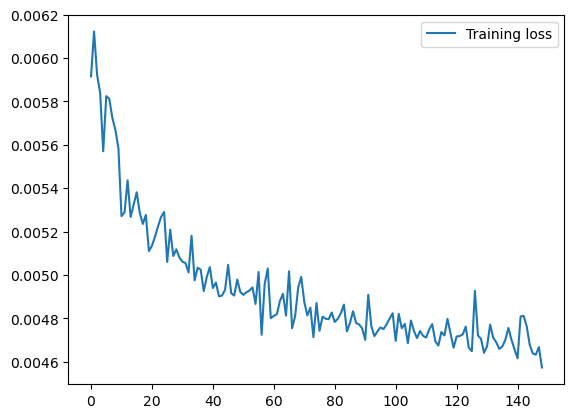

/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0.0186012150581231


In [17]:
# try a model
bc = 16
hidden = 32
layers = 1
dropout = 0.1
lr = 0.005

train_model(x,y, batch_size=bc,hidden_size = hidden, num_layers = layers, dropout_rate = dropout, learning_rate = lr, part_train = part_train, part_valid = part_valid)
pred_Y, true_Y = test_model(x,y, hidden_size = hidden, num_layers = layers, dropout_rate = dropout, part_train = part_train, part_valid = part_valid)
mse = mean_squared_error(true_Y, pred_Y)
print(mse)

In [8]:
pred_Y, true_Y = test_model(x,y, hidden_size = hidden, num_layers = layers, dropout_rate = dropout, part_train = part_train, part_valid = part_valid)
mse = mean_squared_error(true_Y, pred_Y)
print(mse)

/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0.015799871912870113


In [64]:
pd.read_csv('results.csv').sort_values(by='mse')

,Model,Window,layers,hidden,batch_size,dropout,learning_rate,mse,epochs,input_size
24,LSTM,15,1,64,16,0.0,0.0050,0.013232,50.0,1.0
30,LSTM,15,1,64,16,0.0,0.0010,0.015424,50.0,1.0
38,LSTM,15,1,64,16,0.0,0.0050,0.017622,200.0,1.0
20,LSTM,15,1,64,16,0.0,0.0050,0.018151,50.0,1.0
29,LSTM,15,1,64,16,0.0,0.0005,0.019764,50.0,1.0
...,...,...,...,...,...,...,...,...,...,...
63,LSTM,50,3,64,16,0.2,0.0050,1.645080,50.0,8.0
48,LSTM,15,4,32,16,0.2,0.0050,1.765182,50.0,8.0
49,LSTM,15,3,8,16,0.2,0.0050,1.881225,50.0,8.0
64,LSTM,50,3,64,16,0.2,0.0100,1.998019,50.0,8.0


In [67]:
from sklearn.metrics import mean_squared_error
a = pd.read_csv('test_normalised.csv')
a = a["close_AAPL"]
mean_squared_error(a[:-50], a[50:])

0.47096672855229854

In [80]:
# Compute the results
results = pd.read_csv('LSTM_results.csv')

for bc in [16,64]:
    for layers in [1,2,3]:
        for hidden in [8,16,32,64,128]:
            for dropout in [0, 0.1]:
                for lr in [0.05, 0.01]:
                    if len(results[(results['Window'] == timeWindowToUse) & (results['layers'] == layers) & (results['hidden'] == hidden) & (results['batch_size'] == bc) & (results['dropout'] == dropout) & (results['lr'] == lr)]) > 0:
                        continue
                    train_model(x,y, batch_size=bc,hidden_size = hidden, num_layers = layers, dropout_rate = dropout, learning_rate = lr)
                    pred_Y, true_Y = test_model(x,y, hidden_size = hidden, num_layers = layers, dropout_rate = dropout)
                    mse = mean_squared_error(scaler_y.inverse_transform(true_Y.reshape(-1, 1)), scaler_y.inverse_transform(pred_Y.reshape(-1, 1)))
                    print(mse)
                    results = pd.concat([results, pd.DataFrame.from_records([{'Window': timeWindowToUse,'layers': layers,
                                         'hidden': hidden, 'batch_size' : bc,'dropout': dropout, 'lr': lr, 'mse': mse}])])
                    results.to_csv('LSTM_results.csv', index=False)


  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:06<00:30,  2.68it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

1.1723989432624085e+19


 52%|█████▏    | 52/100 [00:17<00:16,  2.90it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

5.332262930686459e+18


 61%|██████    | 61/100 [00:21<00:13,  2.90it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

5.952083269740195e+18


 60%|██████    | 60/100 [00:20<00:13,  2.90it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

5.487318047782164e+18


 21%|██        | 21/100 [00:07<00:27,  2.83it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

6.192973593205392e+18


 39%|███▉      | 39/100 [00:13<00:20,  2.91it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

5.40737792353439e+18


 26%|██▌       | 26/100 [00:09<00:25,  2.87it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

6.373807512177333e+18


 43%|████▎     | 43/100 [00:14<00:19,  2.92it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

5.409817483352008e+18


 56%|█████▌    | 56/100 [00:21<00:16,  2.59it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

5.386642391994144e+18


 29%|██▉       | 29/100 [00:12<00:29,  2.40it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

6.122483967775784e+18


 40%|████      | 40/100 [00:15<00:22,  2.65it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

6.120300072593945e+18


 55%|█████▌    | 55/100 [00:21<00:17,  2.58it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

5.365206332098568e+18


 35%|███▌      | 35/100 [00:17<00:31,  2.03it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

5.396681061844523e+18


 41%|████      | 41/100 [00:18<00:27,  2.17it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

5.25872375248053e+18


 45%|████▌     | 45/100 [00:19<00:24,  2.27it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

5.426036969100071e+18


 51%|█████     | 51/100 [00:22<00:21,  2.29it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

5.18340647287689e+18


 37%|███▋      | 37/100 [00:24<00:41,  1.51it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

6.415757747674821e+18


 45%|████▌     | 45/100 [00:29<00:35,  1.53it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

5.321855999653327e+18


 18%|█▊        | 18/100 [00:12<00:55,  1.49it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

1.1788199903694787e+19


 27%|██▋       | 27/100 [00:17<00:48,  1.51it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

6.948694369842739e+18


  0%|          | 0/100 [00:00<?, ?it/s]

6.429997499528236e+18


  0%|          | 0/100 [00:00<?, ?it/s]

5.588754663094841e+18


  0%|          | 0/100 [00:00<?, ?it/s]

1.2463078776785762e+19


  0%|          | 0/100 [00:00<?, ?it/s]

8.889431785345876e+18


  0%|          | 0/100 [00:00<?, ?it/s]

5.859454970572276e+18


  0%|          | 0/100 [00:00<?, ?it/s]

5.412390336783402e+18


  0%|          | 0/100 [00:00<?, ?it/s]

1.0542383648636254e+19


  0%|          | 0/100 [00:00<?, ?it/s]

8.490138644226982e+18


  0%|          | 0/100 [00:00<?, ?it/s]

5.710026382305457e+18


  0%|          | 0/100 [00:00<?, ?it/s]

5.264307103286992e+18


  0%|          | 0/100 [00:00<?, ?it/s]

9.293755140325499e+18


  0%|          | 0/100 [00:00<?, ?it/s]

5.884773424792076e+18


  0%|          | 0/100 [00:00<?, ?it/s]

1.0292811278765045e+21


  0%|          | 0/100 [00:00<?, ?it/s]

5.629710679487919e+18


  0%|          | 0/100 [00:00<?, ?it/s]

7.068817881539655e+18


  0%|          | 0/100 [00:00<?, ?it/s]

7.247102803302409e+18


  0%|          | 0/100 [00:00<?, ?it/s]

1.3787196891346966e+21


  0%|          | 0/100 [00:00<?, ?it/s]

5.389478656890913e+18


  0%|          | 0/100 [00:00<?, ?it/s]

1.109559165364495e+19


  0%|          | 0/100 [00:00<?, ?it/s]

6.558310532574482e+18


  0%|          | 0/100 [00:00<?, ?it/s]

1.1933599286436768e+19


  0%|          | 0/100 [00:00<?, ?it/s]

5.878577114951249e+18


  0%|          | 0/100 [00:00<?, ?it/s]

1.1630747250176907e+19


  0%|          | 0/100 [00:00<?, ?it/s]

1.3451339853318994e+19


  0%|          | 0/100 [00:00<?, ?it/s]

5.959923520144504e+18


  0%|          | 0/100 [00:00<?, ?it/s]

5.185296188225938e+18


  0%|          | 0/100 [00:00<?, ?it/s]

7.584097470472791e+18


  0%|          | 0/100 [00:00<?, ?it/s]

1.7283116106661845e+19


  0%|          | 0/100 [00:00<?, ?it/s]

2.9149870404202614e+20


  0%|          | 0/100 [00:00<?, ?it/s]

5.437937047084937e+18


  0%|          | 0/100 [00:00<?, ?it/s]

9.379031726304186e+18


  0%|          | 0/100 [00:00<?, ?it/s]

8.048045317913615e+18


  0%|          | 0/100 [00:00<?, ?it/s]

7.832009130707464e+18


  0%|          | 0/100 [00:00<?, ?it/s]

5.544043288939519e+18


  0%|          | 0/100 [00:00<?, ?it/s]

9.628935193550296e+20


  0%|          | 0/100 [00:00<?, ?it/s]

7.765653606304243e+18


  0%|          | 0/100 [00:00<?, ?it/s]

3.814021529265054e+20


  0%|          | 0/100 [00:00<?, ?it/s]

5.319198049737188e+18


  0%|          | 0/100 [00:00<?, ?it/s]

1.2113713406774034e+20


  0%|          | 0/100 [00:00<?, ?it/s]

6.735552614920431e+18


 34%|███▍      | 34/100 [00:06<00:12,  5.22it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  1%|          | 1/100 [00:00<00:16,  5.84it/s]

5.562382944158393e+18


 62%|██████▏   | 62/100 [00:09<00:05,  6.41it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  1%|          | 1/100 [00:00<00:12,  7.84it/s]

6.404682233641883e+18


 37%|███▋      | 37/100 [00:04<00:08,  7.51it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  1%|          | 1/100 [00:00<00:13,  7.10it/s]

5.36688514828928e+18


 49%|████▉     | 49/100 [00:06<00:06,  7.54it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  1%|          | 1/100 [00:00<00:12,  8.02it/s]

5.909238175574601e+18


 53%|█████▎    | 53/100 [00:07<00:07,  6.68it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  1%|          | 1/100 [00:00<00:14,  6.95it/s]

5.251045282080182e+18


 68%|██████▊   | 68/100 [00:13<00:06,  5.09it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

6.401711113391627e+18


 42%|████▏     | 42/100 [00:09<00:12,  4.62it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

5.640865439120378e+18


 85%|████████▌ | 85/100 [00:16<00:02,  5.30it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  1%|          | 1/100 [00:00<00:17,  5.80it/s]

6.656441023229509e+18


 42%|████▏     | 42/100 [00:07<00:09,  5.82it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  1%|          | 1/100 [00:00<00:15,  6.54it/s]

5.720282740049847e+18


 62%|██████▏   | 62/100 [00:10<00:06,  6.10it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  1%|          | 1/100 [00:00<00:14,  6.92it/s]

5.869019978680709e+18


 18%|█▊        | 18/100 [00:02<00:12,  6.37it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  1%|          | 1/100 [00:00<00:14,  6.99it/s]

5.590465818276917e+18


 62%|██████▏   | 62/100 [00:09<00:05,  6.65it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

6.58347135724396e+18


 68%|██████▊   | 68/100 [00:17<00:08,  3.87it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

6.039730023364649e+18


 47%|████▋     | 47/100 [00:12<00:14,  3.68it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

6.394425648198202e+18


 55%|█████▌    | 55/100 [00:14<00:11,  3.78it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

6.022581692897314e+18


 58%|█████▊    | 58/100 [00:14<00:10,  4.06it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

6.216453722456226e+18


 44%|████▍     | 44/100 [00:23<00:29,  1.89it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

2.728517027589544e+19


 87%|████████▋ | 87/100 [17:00<02:32, 11.73s/it]   
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

5.808404962435128e+18


 34%|███▍      | 34/100 [00:57<01:51,  1.69s/it]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

7.386523173965443e+18


 52%|█████▏    | 52/100 [00:27<00:25,  1.90it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

7.202016732795787e+18


  0%|          | 0/100 [00:00<?, ?it/s]

7.028838390634352e+18


  0%|          | 0/100 [00:00<?, ?it/s]

5.736097399322534e+18


  0%|          | 0/100 [00:00<?, ?it/s]

9.685706337483848e+18


  0%|          | 0/100 [00:00<?, ?it/s]

9.145009439946363e+18


  0%|          | 0/100 [00:00<?, ?it/s]

6.873947519213724e+18


  0%|          | 0/100 [00:00<?, ?it/s]

5.793246973168032e+18


  0%|          | 0/100 [00:00<?, ?it/s]

8.911899075165961e+18


  0%|          | 0/100 [00:00<?, ?it/s]

1.1800499842736364e+19


  0%|          | 0/100 [00:00<?, ?it/s]

5.560638478351759e+18


  0%|          | 0/100 [00:00<?, ?it/s]

7.487045204333701e+18


  0%|          | 0/100 [00:00<?, ?it/s]

1.1345579201652374e+19


  0%|          | 0/100 [00:00<?, ?it/s]

1.0968847342452105e+19


  0%|          | 0/100 [00:00<?, ?it/s]

5.389564265245289e+18


  0%|          | 0/100 [00:00<?, ?it/s]

5.877454942384017e+18


  0%|          | 0/100 [00:00<?, ?it/s]

6.108201946559511e+20


  0%|          | 0/100 [00:00<?, ?it/s]

8.606646939523025e+18


  0%|          | 0/100 [00:00<?, ?it/s]

2.131151189821971e+20


  0%|          | 0/100 [00:00<?, ?it/s]

6.27900098790304e+18


  0%|          | 0/100 [00:00<?, ?it/s]

1.0139749018307692e+20


  0%|          | 0/100 [00:00<?, ?it/s]

8.247904960976994e+18


  0%|          | 0/100 [00:00<?, ?it/s]

1.0085502312310315e+19


  0%|          | 0/100 [00:00<?, ?it/s]

7.657893062083876e+18


  0%|          | 0/100 [00:00<?, ?it/s]

1.8392942556965759e+19


  0%|          | 0/100 [00:00<?, ?it/s]

9.142439819292141e+18


  0%|          | 0/100 [00:00<?, ?it/s]

5.502680548729695e+18


  0%|          | 0/100 [00:00<?, ?it/s]

5.918114257449554e+18


  0%|          | 0/100 [00:00<?, ?it/s]

8.996567550414539e+18


  0%|          | 0/100 [00:00<?, ?it/s]

1.995010105970973e+19


  0%|          | 0/100 [00:00<?, ?it/s]

1.7002554459427547e+20


  0%|          | 0/100 [00:00<?, ?it/s]

5.672923099677619e+18


  0%|          | 0/100 [00:00<?, ?it/s]

1.0986390747978844e+20


  0%|          | 0/100 [00:00<?, ?it/s]

1.0824886352894974e+19


  0%|          | 0/100 [00:00<?, ?it/s]

2.2078504738203353e+20


  0%|          | 0/100 [00:00<?, ?it/s]

7.377780948580362e+18


  0%|          | 0/100 [00:00<?, ?it/s]

1.348218182657432e+19


  0%|          | 0/100 [00:00<?, ?it/s]

7.522855466606004e+18


 33%|███▎      | 33/100 [01:08<02:18,  2.07s/it]


4.5974132097165754e+20


  0%|          | 0/100 [00:00<?, ?it/s]

5.49695037269725e+18


 24%|██▍       | 24/100 [33:22<1:45:42, 83.45s/it] 


1.5071365699796648e+20


 30%|███       | 30/100 [01:36<03:44,  3.21s/it]


9.069652897890093e+18
